In [1]:
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock, ProjectBlock

In [2]:
import matplotlib.pyplot as plt

In [3]:
class OptimisationProgress(object):
    m_progress = []
    J_progress = []

In [4]:
op = OptimisationProgress()

In [5]:
n = 100
l = 10.0
h = Constant(l/n)
mesh = IntervalMesh(n, l)
x, = SpatialCoordinate(mesh)

In [6]:
m_opt = 1.0
m_prior = 0.1

In [7]:
num_timesteps = 10
dt = Constant(0.1)

In [8]:
P2 = FunctionSpace(mesh, "CG", 1)
P1 = FunctionSpace(mesh, "CG", 1)
V = P2*P1
R = FunctionSpace(mesh, "R", 0)
Constant = lambda _: Function(R).assign(_)

In [9]:
u, eta = TrialFunctions(V)
z, zeta = TestFunctions(V)
m = Constant(m_prior)
c = Control(m)
eta0 = Function(P1)
eta0.interpolate(conditional(And(ge(x, 1), le(x, 2)), abs(sin(pi*x)), 0))
q_ = Function(V)
u_, eta_ = q_.split()
eta_.project(m*eta0);

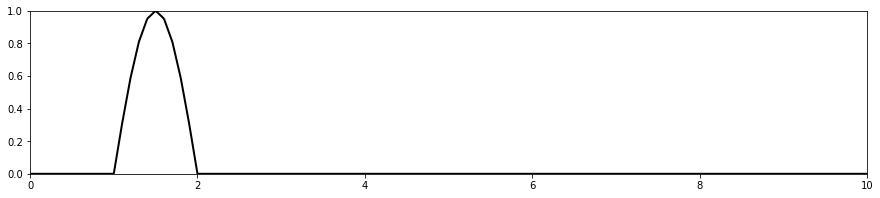

In [10]:
fig, axes = plt.subplots(figsize=(15, 3))
plot(eta0, axes=axes)
axes.set_xlim([0, l])
axes.set_ylim([0, 1]);

In [11]:
b = Constant(1.0)
g = Constant(9.81)

In [12]:
a = u*z*dx + eta*zeta*dx + dt*g*eta.dx(0)*z*dx - dt*b*u*zeta.dx(0)*dx
L = u_*z*dx + eta_*zeta*dx
q = Function(V)
u, eta = q.split()
bc = DirichletBC(V.sub(1), 0, 2)

In [13]:
scaling = Constant(1.0)

In [14]:
P0 = FunctionSpace(mesh, "DG", 0)
k = Function(P0*P0)
ku, keta = k.split()
keta.interpolate(conditional(And(ge(x, 4), le(x, 4+h)), 1, 0))
qd = Function(V)
ud, etad = qd.split()
# J_form = dt*inner(k, q - qd)*inner(k, q - qd)*dx
# J_form = dt*inner(k, q - qd)*dx
J_form = scaling*0.5*dt*keta*(eta - etad)**2*dx

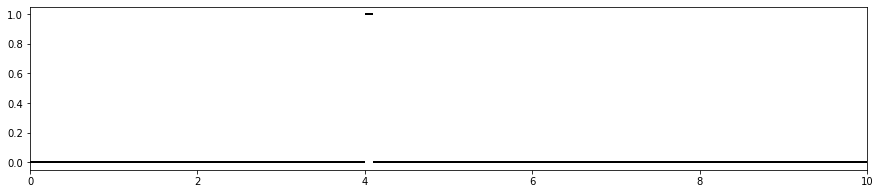

In [15]:
fig, axes = plt.subplots(figsize=(15, 3))
plot(keta, axes=axes)
axes.set_xlim([0, l]);

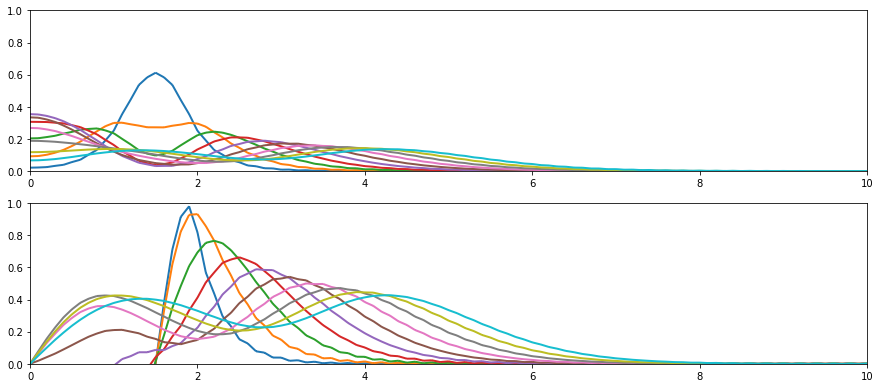

In [16]:
with stop_annotating():
    data = []
    u_.assign(0.0)
    eta_.project(m_opt*eta0)
    fig, axes = plt.subplots(nrows=2, figsize=(15, 6.5))
    for i in range(num_timesteps):
        solve(a == L, q, bcs=bc)
        q_.assign(q)
#         data.append(assemble(keta*eta/h*dx))  # Very accurate
        data.append(float(eta.at(4+0.5*l/n)))  # Very accurate (same)
#         data.append(float(eta.at(4+0.1*l/n)))  # Less accurate
        plot(eta, axes=axes[0], edgecolor=f"C{i}")
        plot(u, axes=axes[1], edgecolor=f"C{i}")
axes[0].set_xlim([0, l])
axes[0].set_ylim([0, 1])
axes[1].set_xlim([0, l])
axes[1].set_ylim([0, 1]);

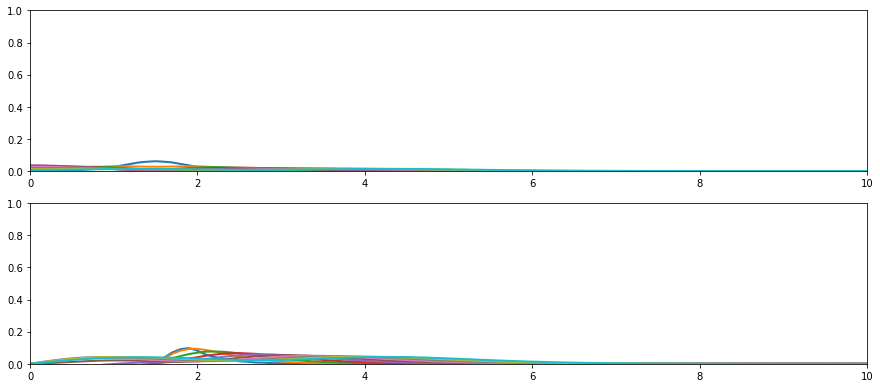

In [17]:
J = 0
fig, axes = plt.subplots(nrows=2, figsize=(15, 6.5))
u_.assign(0.0)
eta_.project(m*eta0)
for i in range(num_timesteps):
    solve(a == L, q, bcs=bc)
    q_.assign(q)
    etad.assign(data[i])
    J += assemble(J_form)
    plot(eta, axes=axes[0], edgecolor=f"C{i}")
    plot(u, axes=axes[1], edgecolor=f"C{i}")
axes[0].set_xlim([0, l])
axes[0].set_ylim([0, 1])
axes[1].set_xlim([0, l])
axes[1].set_ylim([0, 1]);

In [18]:
stop_annotating();

In [19]:
def cb(j, djdm, ctrl):
    op.m_progress.append(ctrl.dat.data[0])
    op.J_progress.append(j)
    print(f"{ctrl.dat.data[0]:.8e} {j:.8e} {norm(djdm):.8e}")

In [20]:
Jhat = ReducedFunctional(J, c, derivative_cb_post=cb)
m.assign(minimize(Jhat, method='BFGS'))
u_.assign(0.0)
eta_.project(m*eta0);

1.00000000e-01 3.36479119e-04 4.72880148e-03
1.01495378e-01 3.35361970e-04 4.72094044e-03
1.07476892e-01 3.30911961e-04 4.68949626e-03
1.31402945e-01 3.13409313e-04 4.56371955e-03
2.27107158e-01 2.48156905e-04 4.06061269e-03
3.66047943e-01 1.66974319e-04 3.33021578e-03
5.21767040e-01 9.50574104e-05 2.51161707e-03
7.04673461e-01 3.63249272e-05 1.55009749e-03
9.46704307e-01 1.35016655e-06 2.77767114e-04
9.99542949e-01 1.89860689e-07 1.24147376e-18


In [21]:
print(f"Relative error = {100*abs((m.dat.data[0] - m_opt)/m_opt):.4f}%")

Relative error = 0.0457%


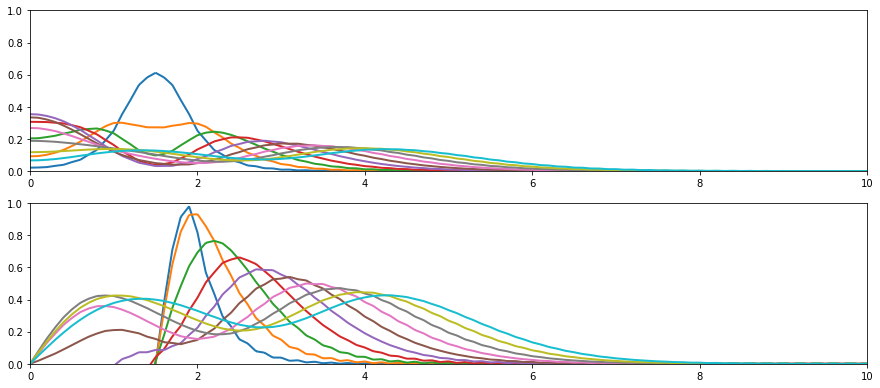

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 6.5))
for i in range(num_timesteps):
    solve(a == L, q, bcs=bc)
    q_.assign(q)
    plot(eta, axes=axes[0], edgecolor=f"C{i}")
    plot(u, axes=axes[1], edgecolor=f"C{i}")
axes[0].set_xlim([0, l])
axes[0].set_ylim([0, 1])
axes[1].set_xlim([0, l])
axes[1].set_ylim([0, 1]);